In [2]:
%matplotlib inline

# Halt Training at the Right Time with `Early Stopping`
`
By   : Dr. James G. Shanahan
EMAIL: James.Shanahan AT Gmail.com`

A major challenge in machine learning is how long to train a model. Too little training
will mean that the model will underfit the train and the test sets. Too much training will
mean that the model will overfit the training dataset and have poor performance on the test
set. A compromise is to train on the training dataset but to stop training at the point when
performance on a validation dataset starts to degrade. This simple, effective, and widely used
approach to training a model, be it a linear regression modle or a neural network is called early stopping. In this lab, you will discover
that stopping the training of a model early before it has overfit the training dataset
can reduce overfitting and improve the generalization of deep neural networks. After reading
this lab, you will know:

* The challenge of training a model (e.g., a decision tree, an ensemble of decision trees, a neural network as we will see later) long enough to learn the mapping, but not so long that it overfits the training data.
*  Model performance on a holdout validation dataset can be monitored during training and training stopped when generalization error starts to increase.
* The use of early stopping requires the selection of a performance measure to monitor, a trigger to stop training, and a selection of the model weights to use.

Early stopping is an approach to training complex machine learning models to avoid overfitting.

It works by monitoring the performance of the model that is being trained on a separate test dataset and stopping the training procedure once the performance on the test dataset has not improved after a fixed number of training iterations.

It avoids overfitting by attempting to automatically select the inflection point where performance on the test dataset starts to decrease while performance on the training dataset continues to improve as the model starts to overfit.

The performance measure may be the loss function that is being optimized to train the model (such as logarithmic loss), or an external metric of interest to the problem in general (such as classification accuracy).

### Lab Takeways
In this Lab you will:

* Learn that early stopping is an approach to training complex machine learning models to avoid overfitting.
* Discover how you can use early stopping to limit overfitting with SKLearn in the context of linear models.
* Discover how you can use early stopping to limit overfitting with XGBoost in Python.
* See early stopping in action for a few of different datasets

### References
* https://en.wikipedia.org/wiki/Early_stopping

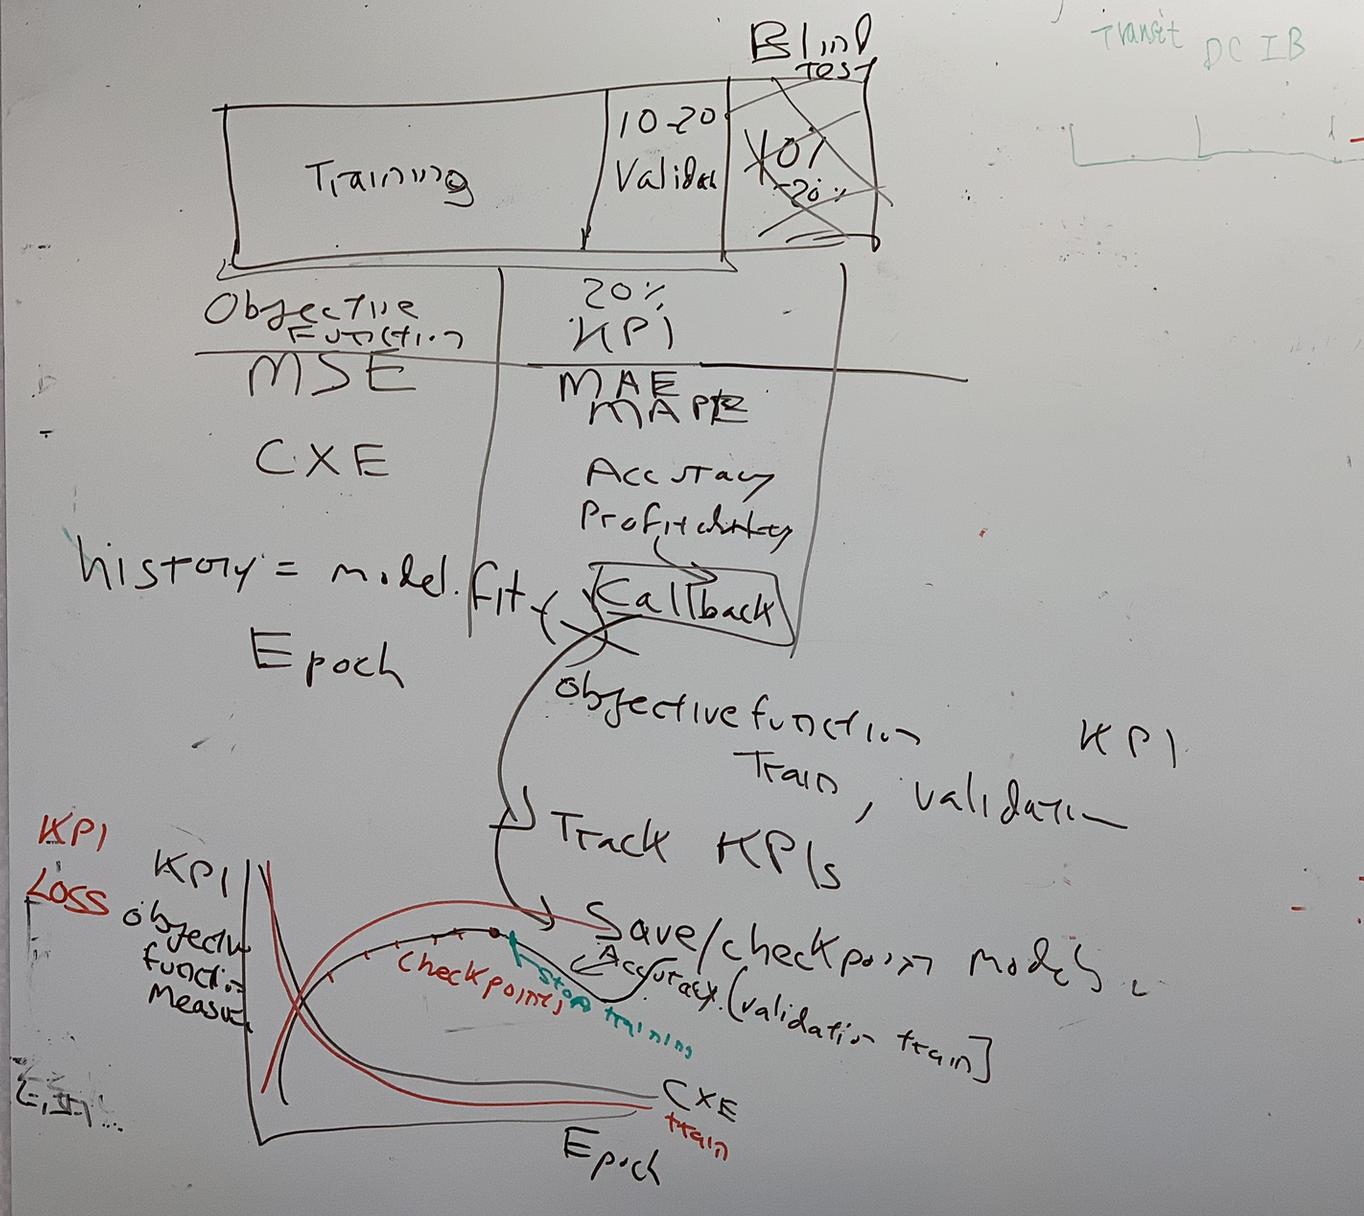

## When to Use Early Stopping
Early stopping is so easy to use, e.g. with the simplest trigger, that there is little reason to not
use it when training a model. Use of early stopping may be a staple of the modern
training of models like ensembles of decision trees and deep neural networks.

**Early stopping should be used almost universally.**

### Plot Learning Curves to Select a Trigger
Before using early stopping, it may be interesting to fit an `under constrained` model and monitor
the performance of the model on a train and validation dataset. Plotting the performance of the
model in real-time or at the end of a long run will show how noisy the training process is with
your specific model and dataset. This may help in the choice of a trigger for early stopping.

#### Monitor an Important Metric for your domain (not for the machine learning algo.)
Loss is an easy metric to monitor during training and to trigger early stopping. The problem is
that loss does not always capture what is most important about the model to you and your
project.

Sometimes, the loss function we actually care about (say classification error) is not
one that can be optimized efficiently. In such situations, one typically optimizes
a surrogate loss function instead, which acts as a proxy but has advantages.

It may be better to choose a performance metric to monitor that best defines the performance
of the model in terms of the way you intend to use it. This may be the metric that you intend
to use to report the performance of the model.


# SKLearn: Early stopping of Stochastic Gradient Descent


Stochastic Gradient Descent is an optimization technique which minimizes a loss
function in a stochastic fashion, performing a gradient descent step sample by
sample. In particular, it is a very efficient method to fit linear models.

As a stochastic method, the loss function is not necessarily decreasing at each
iteration, and convergence is only guaranteed in expectation. For this reason,
monitoring the convergence on the loss function can be difficult.

Another approach is to monitor convergence on a validation score. In this case,
the input data is split into a training set and a validation set. The model is
then fitted on the training set and the stopping criterion is based on the
prediction score computed on the validation set. This enables us to find the
least number of iterations which is sufficient to build a model that
generalizes well to unseen data and reduces the chance of over-fitting the
training data.


## Early stopping for SGDClassifier and SGDRegressor
The SKLearn classes `SGDClassifier` and `SGDRegressor` provide two criteria to stop the algorithm when a given level of convergence is reached:

With `early_stopping=True`, the input data is split into a training set and a validation set. The model is then fitted on the training set, and the stopping criterion is based on the prediction score computed on the validation set. The size of the validation set can be changed with the parameter validation_fraction.
With `early_stopping=False`, the model is fitted on the entire input data and the stopping criterion is based on the objective function computed on the input data.
In both cases, the criterion is evaluated once by epoch, and the algorithm stops when the criterion does not improve `n_iter_no_change` times in a row. The improvement is evaluated with a tolerance tol, and the algorithm stops in any case after a maximum number of iteration max_iter.

This early stopping strategy is activated if `early_stopping=True`; otherwise
the stopping criterion only uses the training loss on the entire input data. To
better control the early stopping strategy, we can specify a parameter
``validation_fraction`` which set the fraction of the input dataset that we
keep aside to compute the validation score. The optimization will continue
until the validation score did not improve by at least ``tol`` during the last
``n_iter_no_change`` iterations. The actual number of iterations is available
at the attribute ``n_iter_``.


## MNIST and Early stopping (select 2 of 10 class handwritten digits dataset)

This example illustrates how the early stopping can used in the
:class:`sklearn.linear_model.SGDClassifier` model to achieve almost the same
accuracy as compared to a model built without early stopping. This can
significantly reduce training time. Note that scores differ between the
stopping criteria even from early iterations because some of the training data
is held out with the validation stopping criterion.


We train explicitly for 50 epochs but exploit early stopping when possible. 

Notice how:
* training time will be radically reduced for training those models with early stopping based on the validation error
* training time may or maynot be reduced for training those models with early stopping based on the training error. **Why?**





In [11]:
%%time
# Adopted from  Authors: Tom Dupre la Tour
#
# License: BSD 3 clause
# with modifications by James G. Shanahan
from __future__ import print_function
import time
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import shuffle

print(__doc__)


def load_mnist(n_samples=None, class_0='0', class_1='8'):
    """Load MNIST, select two classes, shuffle and return only n_samples."""
    # Load data from http://openml.org/d/554
    mnist = fetch_openml('mnist_784', version=1)

    # take only two classes for binary classification
    mask = np.logical_or(mnist.target == class_0, mnist.target == class_1)

    X, y = shuffle(mnist.data[mask], mnist.target[mask], random_state=42)
    if n_samples is not None:
        X, y = X[:n_samples], y[:n_samples]
    return X, y


@ignore_warnings(category=ConvergenceWarning)
def fit_and_score(estimator, max_iter, X_train, X_valid, y_train, y_valid):
    """ Fit the estimator on the train set and score it on both sets
        Returns 
            fit_time, 
            n_iter,
            the mean accuracy on the given datasets and corresponding labels.
       """
    estimator.set_params(max_iter=max_iter)
    estimator.set_params(random_state=0)

    start = time.time()
    estimator.fit(X_train, y_train)

    fit_time = time.time() - start
    n_iter = estimator.n_iter_
    train_score = estimator.score(X_train, y_train)  # accuracy
    valid_score = estimator.score(X_valid, y_valid)  # accuracy

    return fit_time, n_iter, train_score, valid_score


# Define the estimators to compare
estimator_dict = {
    'No stopping criterion':
    linear_model.SGDClassifier(tol=None, n_iter_no_change=3),
    'Training loss':
    linear_model.SGDClassifier(early_stopping=False, n_iter_no_change=3,
                               tol=0.1),
    'Validation score':
    linear_model.SGDClassifier(early_stopping=True, n_iter_no_change=3,
                               tol=0.0001, validation_fraction=0.2)
}

# Load the dataset
X, y = load_mnist(n_samples=10000) # load ~20% of the data for illustration purposes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)

# NOTE: the generate validation set created here is not used in this code
# BUT please modify code to use the validation set provided as opposed to using
# the validation_fraction=0.2 during training
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2,
                                                    random_state=0)

#  Train explicitly for 50 epochs but exploit early stopping when possible.
#  Training time will be radically reduced for training those models
#
results = []
for estimator_name, estimator in estimator_dict.items():
    print(estimator_name + ': ', end='')
    for max_iter in range(1, 50):
        print('.', end='')
        sys.stdout.flush()

        fit_time, n_iter, train_score, valid_score = fit_and_score(
            estimator, max_iter, X_train, X_valid, y_train, y_valid)

        results.append((estimator_name, max_iter, fit_time, n_iter,
                        train_score, valid_score))
    print('')

Automatically created module for IPython interactive environment
No stopping criterion: ....

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19.

...

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19.

..

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


..

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


..

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


..

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


..

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


..

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


..

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


..

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


.

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)



Training loss: .................................................
Validation score: .................................................
CPU times: user 49.9 s, sys: 1.17 s, total: 51.1 s
Wall time: 51 s


### Looks at the training log epoch by epoch

In [35]:
print(f"{results_df.head(10).values[0:10]}" )

[['No stopping criterion' 1 0.019340991973876953 1 0.99171875 0.990625]
 ['No stopping criterion' 2 0.029235124588012695 2 0.99234375 0.98875]
 ['No stopping criterion' 3 0.037392616271972656 3 0.97171875 0.973125]
 ['No stopping criterion' 4 0.04565906524658203 4 0.989375 0.991875]
 ['No stopping criterion' 5 0.0652163028717041 5 0.9940625 0.99]
 ['No stopping criterion' 6 0.06497049331665039 6 0.994375 0.99125]
 ['No stopping criterion' 7 0.08207130432128906 7 0.985 0.98125]
 ['No stopping criterion' 8 0.07964181900024414 8 0.9928125 0.988125]
 ['No stopping criterion' 9 0.10385465621948242 9 0.9809375 0.9825]
 ['No stopping criterion' 10 0.13794565200805664 10 0.99171875 0.985625]]


In [18]:
results_df.shape

(147, 6)

In [21]:
results_df[45:55]

,Stopping criterion,max_iter,Fit time (sec),n_iter_,Train Accuracy,Validation Accuracy
45,No stopping criterion,46,0.517662,46,0.995156,0.988125
46,No stopping criterion,47,0.495971,47,0.996719,0.988125
47,No stopping criterion,48,0.475574,48,0.997344,0.987500
48,No stopping criterion,49,0.431754,49,0.992031,0.985625
49,Training loss,1,0.022483,1,0.991719,0.990625
50,Training loss,2,0.036330,2,0.992344,0.988750
51,Training loss,3,0.040342,3,0.971719,0.973125
52,Training loss,4,0.045171,4,0.989375,0.991875
53,Training loss,5,0.051062,5,0.994062,0.990000
54,Training loss,6,0.068033,6,0.994375,0.991250


In [22]:
results_df[95:105]

,Stopping criterion,max_iter,Fit time (sec),n_iter_,Train Accuracy,Validation Accuracy
95,Training loss,47,0.248323,30,0.995313,0.989375
96,Training loss,48,0.250254,30,0.995313,0.989375
97,Training loss,49,0.254047,30,0.995313,0.989375
98,Validation score,1,0.033318,1,0.990781,0.988125
99,Validation score,2,0.044498,2,0.992188,0.989375
100,Validation score,3,0.057359,3,0.960000,0.961250
101,Validation score,4,0.068868,4,0.988281,0.990625
102,Validation score,5,0.065994,4,0.988281,0.990625
103,Validation score,6,0.068565,4,0.988281,0.990625
104,Validation score,7,0.077108,4,0.988281,0.990625


In [16]:
results_df.tail()

,Stopping criterion,max_iter,Fit time (sec),n_iter_,Train Accuracy,Validation Accuracy
142,Validation score,45,0.067601,4,0.988281,0.990625
143,Validation score,46,0.076676,4,0.988281,0.990625
144,Validation score,47,0.068919,4,0.988281,0.990625
145,Validation score,48,0.068231,4,0.988281,0.990625
146,Validation score,49,0.070114,4,0.988281,0.990625


### plot the results of early stopping versus not

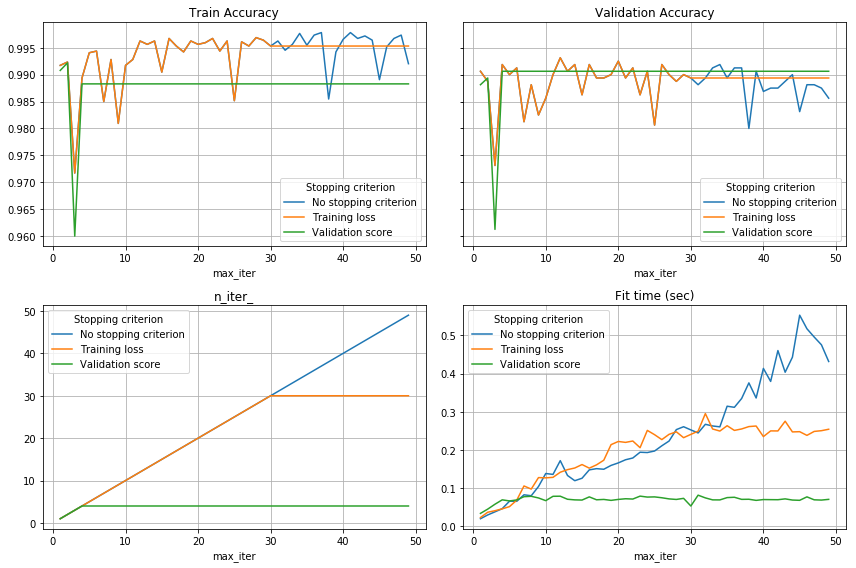

In [19]:
# Transform the results in a pandas dataframe for easy plotting
columns = [
    'Stopping criterion', 'max_iter', 'Fit time (sec)', 'n_iter_',
    'Train Accuracy', 'Validation Accuracy'
]

results_df = pd.DataFrame(results, columns=columns)

# Define what to plot (x_axis, y_axis)
lines = 'Stopping criterion'
plot_list = [
    ('max_iter', 'Train Accuracy'),
    ('max_iter', 'Validation Accuracy'),
    ('max_iter', 'n_iter_'),
    ('max_iter', 'Fit time (sec)'),
]


nrows = 2
ncols = int(np.ceil(len(plot_list) / 2.))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols,
                                                            4 * nrows))
axes[0, 0].get_shared_y_axes().join(axes[0, 0], axes[0, 1])

#plot the results
for ax, (x_axis, y_axis) in zip(axes.ravel(), plot_list):
    for criterion, group_df in results_df.groupby(lines):
        group_df.plot(x=x_axis, y=y_axis, label=criterion, ax=ax, grid=True)
    ax.set_title(y_axis)
    ax.legend(title=lines)

fig.tight_layout()
plt.show()

#### Discussion

When early stopping is employed on the validation set accuracy, training the multinomial logistic regression model stops after 4 epochs. Here is trace of the epoch-by-epoch training with some annotation: 

```python
print(f"{results_df.head(10).values[0:10]}" )
 Stopping criterion	max_iter FitTime(sec) n_iter TrainAcc ValidAccuracy
[['No stopping criterion' 1   0.019         1  0.99171875 0.990625]
 ['No stopping criterion' 2   0.029         2  0.99234375 0.98875]
 ['No stopping criterion' 3   0.037         3  0.97171875 0.973125]
 ['No stopping criterion' 4   0.045         4  0.989375   0.991]     Validation Accurry Maxes out at 0.991
 ['No stopping criterion' 5   0.065         5  0.9940625  0.99]      no improvement
 ['No stopping criterion' 6   0.064         6  0.994375   0.99125]   no improvement
 ['No stopping criterion' 7   0.082         7  0.985      0.98125]   no improvement
 ['No stopping criterion' 8   0.079         8  0.9928125  0.988125]  So stop training
 ['No stopping criterion' 9   0.103         9  0.9809375  0.9825]
 ['No stopping criterion' 10  0.137        10  0.991718  0.985625]]

```

Notice that we   explicitly train the multinomial logistic regression model for 50 epochs but exploit early stopping when possible thus reducing the training time. 

Notice how:
* training time will be radically reduced for training those models with early stopping based on the validation error
* training time may or maynot be reduced for training those models with early stopping based on the training error. **Why?**



## GridSearchCV an Early stopping: Iris



```python

pipe_model = Pipeline([('scaler', MinMaxScaler()),
                  ('classifier', SGDClassifier(loss='log', penalty='l2', 
                                               early_stopping=True, validation_fraction=0.1,n_iter_no_change=5,
                                               tol=1e-3,
                                               max_iter=100000,  random_state=0))
                 ])

```

In [115]:
%%time
import numpy as np
import pandas as pd

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

iris = load_iris()

X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_idx = list(cv.split(X_train, y_train))

pipe_model = Pipeline([('scaler', MinMaxScaler()),
                  ('classifier', SGDClassifier(loss='log', penalty='l2', 
                                               early_stopping=True, validation_fraction=0.1,n_iter_no_change=5,
                                               tol=1e-3,
                                               max_iter=100000,  random_state=0))
                 ])

#Early stopping
fit_params={"classifier__loss":'hinge',
            "classifier__early_stopping":True, 
            "classifier__n_iter_no_change" : 3,
            "classifier__validation_fraction": 0.2}

param_grid = {'classifier__penalty':['l1','l2'], 
              'classifier__alpha': [0.1, 0.010, 0.001]
             }

gs = GridSearchCV(pipe_model, param_grid, cv=5, 
                  verbose=1 
                  
                 )
model = gs.fit(X_train, y_train)# **fit_params)
model.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 400 ms, sys: 0 ns, total: 400 ms
Wall time: 391 ms


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.4s finished
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## MNIST: Early stopping and GridSearchCV

### Pipelining: chaining a PCA and a logistic regression

The PCA does an unsupervised dimensionality reduction, while the logistic regression does the prediction.

We use a GridSearchCV to set the dimensionality of the PCA.



Automatically created module for IPython interactive environment
Best parameter (CV score=0.924):
{'logistic__alpha': 0.01, 'pca__n_components': 64}


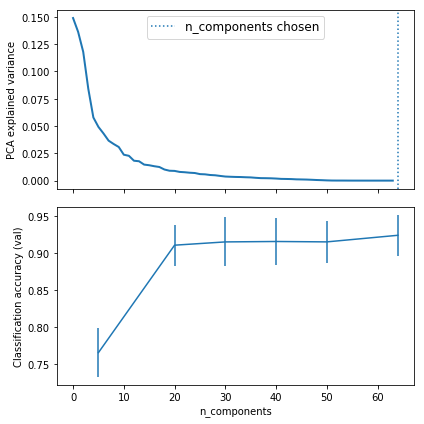

In [3]:
print(__doc__)


# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
logistic = SGDClassifier(loss='log', penalty='l2', early_stopping=True,
                         max_iter=10000, tol=1e-5, random_state=0)
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [5, 20, 30, 40, 50, 64],
    'logistic__alpha': np.logspace(-4, 4, 5),
}
search = GridSearchCV(pipe, param_grid, iid=False, cv=5,
                      return_train_score=False)
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X_digits)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.tight_layout()
plt.show()

# TASK: use logLoss as the early stopping criteria

Modify previous section and use logLoss as the early stopping criteria and rerun all experiments. 

Is using validation logLoss as the early stopping criteria a good optimal choice for early stopping?


# xgboost and GridSearch: Early stopping simple example

## Early stopping in boosted DTs is DIFFERENT (truncated ensembles)

The returned result of using early stopping in the context of training a ensemble of  decision trees is generally a **truncated ensemble** (if early stopping is engaged), i.e., an ensemble consisting m trees eventhough you specified n trees (via `num_boost_round (int) – Number of boosting iterations.`), where $m \le n$. 

You can train decision tree ensemble using the xgboost Library via the following training routine(Note: other exist also):

```python

xgboost.train(params, dtrain, num_boost_round=10, evals=(), obj=None, feval=None, maximize=False, 
              early_stopping_rounds=None, evals_result=None, 
              verbose_eval=True, xgb_model=None, callbacks=None, learning_rates=None)
Train a booster with given parameters.
```

Note that when `early_stopping_rounds` is set, it  activates early stopping. Validation error needs to decrease at least every early_stopping_rounds round(s) to continue training. It returns the model from the last iteration (not the best one). If early stopping occurs, the model will have three additional fields: bst.best_score, bst.best_iteration and bst.best_ntree_limit. (Use bst.best_ntree_limit to get the correct value if num_parallel_tree and/or num_class appears in the parameters)




When using `early_stopping_rounds` you also have to give `eval_metric` and `eval_set` as input parameter for the `fit method`. Early stopping is done via calculating the error on an evaluation or vaidation set. The error has to decrease every early_stopping_rounds otherwise the generation of additional trees is stopped early.

See the [documentation of `xgboosts`](http://xgboost.readthedocs.io/en/latest/python/python_api.html) fit method for details.

Here you see a minimal fully working example:

In [5]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

cv = 2

X_train= [[1.1], [2], [3.3], [4.4], [5.2]]
y_train = [1, 2.5, 3, 4.1, 5.6]

X_valid= [[1.2], [1.5], [4.9], [4.1], [5.9]]
y_valid = [0, 2, 5, 4, 5.4]

X_test= [[0.2], [1.95], [5.9], [3], [7.9]]
y_test = [0.3, 2.4, 6, 4, 6.4]
# these are the evaluation sets

paramGrid = {"subsample" : [0.5, 0.8]}

fit_params={"early_stopping_rounds":3, 
            "eval_metric" : "mae", 
            "eval_set" : [[X_valid, y_valid]]}

model = xgb.XGBRegressor()
gridsearch = GridSearchCV(model, paramGrid, verbose=1 ,
         fit_params=fit_params,
         cv=TimeSeriesSplit(n_splits=cv).get_n_splits([X_valid,y_valid]))
model = gridsearch.fit(X_train,y_train)
model

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[0]	validation_0-mae:2.98
Will train until validation_0-mae hasn't improved in 3 rounds.
[1]	validation_0-mae:2.98
[2]	validation_0-mae:2.827
[3]	validation_0-mae:2.6632
[4]	validation_0-mae:2.51032
[5]	validation_0-mae:2.3808
[6]	validation_0-mae:2.30276
[7]	validation_0-mae:2.22863
[8]	validation_0-mae:2.15819
[9]	validation_0-mae:2.09129
[10]	validation_0-mae:2.06257
[11]	validation_0-mae:2.06257
[12]	validation_0-mae:2.06257
[13]	validation_0-mae:2.06257
Stopping. Best iteration:
[10]	validation_0-mae:2.06257

[0]	validation_0-mae:2.98
Will train until validation_0-mae hasn't improved in 3 rounds.
[1]	validation_0-mae:2.905
[2]	validation_0-mae:2.82
[3]	validation_0-mae:2.753
[4]	validation_0-mae:2.68935
[5]	validation_0-mae:2.63839
[6]	validation_0-mae:2.58047
[7]	validation_0-mae:2.58047
[8]	validation_0-mae:2.58047
[9]	validation_0-mae:2.51175
[10]	validation_0-mae:2.46017
[11]	validation_0-mae:2.39786
[12]	validation_0-

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[19]	validation_0-mae:1.78225
[20]	validation_0-mae:1.77614
[21]	validation_0-mae:1.77033
[22]	validation_0-mae:1.75298
[23]	validation_0-mae:1.71833
[24]	validation_0-mae:1.68541
[25]	validation_0-mae:1.65414
[26]	validation_0-mae:1.63729
[27]	validation_0-mae:1.63415
[28]	validation_0-mae:1.60544
[29]	validation_0-mae:1.57817
[30]	validation_0-mae:1.55226
[31]	validation_0-mae:1.52765
[32]	validation_0-mae:1.51474
[33]	validation_0-mae:1.49201
[34]	validation_0-mae:1.49031
[35]	validation_0-mae:1.47874
[36]	validation_0-mae:1.45849
[37]	validation_0-mae:1.44057
[38]	validation_0-mae:1.45048
[39]	validation_0-mae:1.43296
[40]	validation_0-mae:1.43296
[41]	validation_0-mae:1.41631
[42]	validation_0-mae:1.42481
[43]	validation_0-mae:1.42481
[44]	validation_0-mae:1.40857
[45]	validation_0-mae:1.40854
[46]	validation_0-mae:1.40852
[47]	validation_0-mae:1.39309
[48]	validation_0-mae:1.37844
[49]	validation_0-mae:1.36451
[50]	validation_0-mae:1.35129
[51]	validation_0-mae:1.34119
[52]	valid

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={'early_stopping_rounds': 3, 'eval_metric': 'mae', 'eval_set': [[[[1.2], [1.5], [4.9], [4.1], [5.9]], [0, 2, 5, 4, 5.4]]]},
       iid='warn', n_jobs=None, param_grid={'subsample': [0.5, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [39]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

cv = 2

X_train= [[1.1], [2], [3.3], [4.4], [5.2]]
y_train = [1, 2.5, 3, 4.1, 5.6]

X_valid= [[1.2], [1.5], [4.9], [4.1], [5.9]]
y_valid = [0, 2, 5, 4, 5.4]

X_test= [[0.2], [1.95], [5.9], [3], [7.9]]
y_test = [0.3, 2.4, 6, 4, 6.4]
# these are the evaluation sets
testX = trainX 
testY = trainY

paramGrid = {"subsample" : [0.5, 0.8]}

fit_params={"early_stopping_rounds":3, 
            "eval_metric" : "mae", 
            "eval_set" : [[X_valid, y_valid]]}

model = xgb.XGBRegressor(n_estimators=500, validation_fraction=0.2,
                         n_iter_no_change=5, tol=0.01,
                         random_state=0, verbose=1)

#jgs
gridsearch = GridSearchCV(model, paramGrid, verbose=1 ,
         fit_params=fit_params,
         cv=TimeSeriesSplit(n_splits=cv).get_n_splits([X_valid,y_valid]))
model = gridsearch.fit(X_train,y_train)
model

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[0]	validation_0-mae:2.98
Will train until validation_0-mae hasn't improved in 3 rounds.
[1]	validation_0-mae:2.98
[2]	validation_0-mae:2.827
[3]	validation_0-mae:2.6632
[4]	validation_0-mae:2.51032
[5]	validation_0-mae:2.3808
[6]	validation_0-mae:2.30276
[7]	validation_0-mae:2.22863
[8]	validation_0-mae:2.15819
[9]	validation_0-mae:2.09129
[10]	validation_0-mae:2.06257
[11]	validation_0-mae:2.06257
[12]	validation_0-mae:2.06257
[13]	validation_0-mae:2.06257
Stopping. Best iteration:
[10]	validation_0-mae:2.06257

[0]	validation_0-mae:2.98
Will train until validation_0-mae hasn't improved in 3 rounds.
[1]	validation_0-mae:2.905
[2]	validation_0-mae:2.82
[3]	validation_0-mae:2.753
[4]	validation_0-mae:2.68935
[5]	validation_0-mae:2.63839
[6]	validation_0-mae:2.58047
[7]	validation_0-mae:2.58047
[8]	validation_0-mae:2.58047
[9]	validation_0-mae:2.51175
[10]	validation_0-mae:2.46017
[11]	validation_0-mae:2.39786
[12]	validation_0-

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[50]	validation_0-mae:1.35129
[51]	validation_0-mae:1.34119
[52]	validation_0-mae:1.34113
[53]	validation_0-mae:1.35805
[54]	validation_0-mae:1.37413
[55]	validation_0-mae:1.37242
Stopping. Best iteration:
[52]	validation_0-mae:1.34113

[0]	validation_0-mae:2.965
Will train until validation_0-mae hasn't improved in 3 rounds.
[1]	validation_0-mae:2.876
[2]	validation_0-mae:2.79293
[3]	validation_0-mae:2.72729
[4]	validation_0-mae:2.66492
[5]	validation_0-mae:2.61518
[6]	validation_0-mae:2.55842
[7]	validation_0-mae:2.49124
[8]	validation_0-mae:2.42854
[9]	validation_0-mae:2.37001
[10]	validation_0-mae:2.31539
[11]	validation_0-mae:2.26441
[12]	validation_0-mae:2.23226
[13]	validation_0-mae:2.20171
[14]	validation_0-mae:2.16563
[15]	validation_0-mae:2.12353
[16]	validation_0-mae:2.08424
[17]	validation_0-mae:2.05403
[18]	validation_0-mae:2.02533
[19]	validation_0-mae:1.9908
[20]	validation_0-mae:1.95856
[21]	validation_0-mae:1.93464
[22]	validation_0-mae:1.90542
[23]	validation_0-mae:1.8

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={'early_stopping_rounds': 3, 'eval_metric': 'mae', 'eval_set': [[[[1.2], [1.5], [4.9], [4.1], [5.9]], [0, 2, 5, 4, 5.4]]]},
       iid='warn', n_jobs=None, param_grid={'subsample': [0.5, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [40]:
model.estimator

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

# Monitoring Training Performance With XGBoost
The XGBoost model can evaluate and report on the performance on a test set for the the model during training.

It supports this capability by specifying both an test dataset and an evaluation metric on the call to model.fit() when training the model and specifying verbose output.

For example, we can report on the binary classification error rate (“error“) on a standalone test set (eval_set) while training an XGBoost model as follows:

```python
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="error", eval_set=eval_set, verbose=True)

```
XGBoost supports a suite of evaluation metrics not limited to:

* “rmse” for root mean squared error.
* “mae” for mean absolute error.
* “logloss” for binary logarithmic loss and “mlogloss” for multi-class log loss (cross entropy).
* “error” for classification error.
* “auc” for area under ROC curve.

The full list is provided in the [Learning Task Parameters](http://xgboost.readthedocs.io/en/latest//parameter.html) section of the XGBoost Parameters webpage.

This section is based on [this webpage](https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/).

For example, we can demonstrate how to track the performance of the training of an XGBoost model on the Pima Indians onset of diabetes dataset, available from the UCI Machine Learning Repository (update: download from here).

The full example is provided below:



In [130]:
# plot learning curve
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
# load data
dataset = loadtxt('pima-indians-diabetes.csv', delimiter=",")
# split data into X and y
X = dataset[:,0:8]
Y = dataset[:,8]
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=7)
# fit model 
# use 100 trees but use early stopping to build a smaller ensemble and thereby prevent overfitting 
model = XGBClassifier(n_estimators=100)
eval_set = [(X_train, y_train), (X_valid, y_valid)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("TEST Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.224756	validation_0-logloss:0.656545	validation_1-error:0.214286	validation_1-logloss:0.657946
[1]	validation_0-error:0.224756	validation_0-logloss:0.627135	validation_1-error:0.214286	validation_1-logloss:0.632226
[2]	validation_0-error:0.226384	validation_0-logloss:0.60186	validation_1-error:0.253247	validation_1-logloss:0.611169
[3]	validation_0-error:0.218241	validation_0-logloss:0.579362	validation_1-error:0.227273	validation_1-logloss:0.590335
[4]	validation_0-error:0.221498	validation_0-logloss:0.561255	validation_1-error:0.220779	validation_1-logloss:0.575502
[5]	validation_0-error:0.221498	validation_0-logloss:0.544296	validation_1-error:0.220779	validation_1-logloss:0.560307
[6]	validation_0-error:0.216612	validation_0-logloss:0.529835	validation_1-error:0.220779	validation_1-logloss:0.548334
[7]	validation_0-error:0.211726	validation_0-logloss:0.516982	validation_1-error:0.227273	validation_1-logloss:0.539305
[8]	validation_0-error:0.211726	validatio

[69]	validation_0-error:0.131922	validation_0-logloss:0.3232	validation_1-error:0.194805	validation_1-logloss:0.463274
[70]	validation_0-error:0.131922	validation_0-logloss:0.322649	validation_1-error:0.194805	validation_1-logloss:0.463488
[71]	validation_0-error:0.13355	validation_0-logloss:0.320626	validation_1-error:0.188312	validation_1-logloss:0.462432
[72]	validation_0-error:0.13355	validation_0-logloss:0.319518	validation_1-error:0.188312	validation_1-logloss:0.462823
[73]	validation_0-error:0.131922	validation_0-logloss:0.317966	validation_1-error:0.181818	validation_1-logloss:0.462167
[74]	validation_0-error:0.131922	validation_0-logloss:0.316939	validation_1-error:0.175325	validation_1-logloss:0.46308
[75]	validation_0-error:0.128664	validation_0-logloss:0.315992	validation_1-error:0.181818	validation_1-logloss:0.463027
[76]	validation_0-error:0.128664	validation_0-logloss:0.313817	validation_1-error:0.181818	validation_1-logloss:0.463091
[77]	validation_0-error:0.128664	vali

## Evaluate XGBoost Models With Learning Curves
We can retrieve the performance of the model on the evaluation dataset and plot it to get insight into how learning unfolded while training.

We provide an array of X and y pairs to the eval_metric argument when fitting our XGBoost model. In addition to a test set, we can also provide the training dataset. This will provide a report on how well the model is performing on both training and test sets during training.



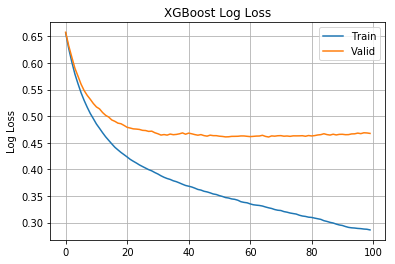

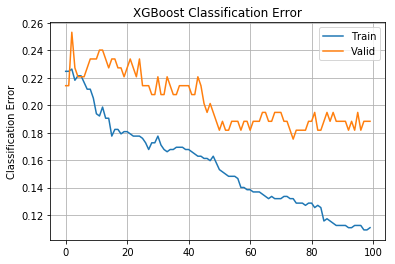

In [125]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Valid')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.grid()
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Valid')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.grid()
pyplot.show()

### Discussion
Running this code reports the classification error on both the train and test datasets each epoch. We can turn this off by setting verbose=False (the default) in the call to the fit() function.

Two plots were created. The first shows the logarithmic loss of the XGBoost model for each epoch on the training and test datasets.

From reviewing the logloss plot, it looks like there is an opportunity to stop the learning early, perhaps somewhere around epoch 45 to epoch 60.

We see a similar story for classification error, where error appears to go back up at around epoch 60.

## Early Stopping With XGBoost: early_stopping_rounds=10
XGBoost supports early stopping after a fixed number of iterations.

In addition to specifying a metric and test dataset for evaluation each epoch, you must specify a window of the number of epochs over which no improvement is observed. This is specified in the early_stopping_rounds parameter.

For example, we can check for no improvement in logarithmic loss over the 10 epochs as follows:

```python
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)
```
If multiple evaluation datasets or multiple evaluation metrics are provided, then early stopping will use the last in the list.

Below provides a full example for completeness with early stopping.

In [129]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
# load data
dataset = loadtxt('pima-indians-diabetes.csv', delimiter=",")
# split data into X and y
X = dataset[:,0:8]
Y = dataset[:,8]
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=7)
# fit model 
# use 100 trees but use early stopping to build a smaller ensemble and thereby prevent overfitting 
model = XGBClassifier(n_estimators=100)
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-logloss:0.657946
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.632226
[2]	validation_0-logloss:0.611169
[3]	validation_0-logloss:0.590335
[4]	validation_0-logloss:0.575502
[5]	validation_0-logloss:0.560307
[6]	validation_0-logloss:0.548334
[7]	validation_0-logloss:0.539305
[8]	validation_0-logloss:0.531899
[9]	validation_0-logloss:0.523915
[10]	validation_0-logloss:0.517477
[11]	validation_0-logloss:0.513849
[12]	validation_0-logloss:0.507
[13]	validation_0-logloss:0.501718
[14]	validation_0-logloss:0.498417
[15]	validation_0-logloss:0.49297
[16]	validation_0-logloss:0.490408
[17]	validation_0-logloss:0.48699
[18]	validation_0-logloss:0.485844
[19]	validation_0-logloss:0.482662
[20]	validation_0-logloss:0.479145
[21]	validation_0-logloss:0.47776
[22]	validation_0-logloss:0.476223
[23]	validation_0-logloss:0.475812
[24]	validation_0-logloss:0.475133
[25]	validation_0-logloss:0.473449
[26]	validation_0-logloss:0.473081
[27

Running the example provides the following output, truncated for brevity:

```python
...
[48]	validation_0-logloss:0.463471
[49]	validation_0-logloss:0.463432
[50]	validation_0-logloss:0.462447
[51]	validation_0-logloss:0.461978
[52]	validation_0-logloss:0.461132
[53]	validation_0-logloss:0.461343
[54]	validation_0-logloss:0.462114
[55]	validation_0-logloss:0.462166
[56]	validation_0-logloss:0.462295
[57]	validation_0-logloss:0.462918
[58]	validation_0-logloss:0.462871
[59]	validation_0-logloss:0.462235
[60]	validation_0-logloss:0.46168
[61]	validation_0-logloss:0.462099
[62]	validation_0-logloss:0.462628
Stopping. Best iteration:
[52]	validation_0-logloss:0.461132

Accuracy: 81.82%```

### Discussion: early_stopping_rounds is set to 10% of training budget
We can see that the model stopped training at epoch 52 (close to what we expected by our manual judgment of learning curves) and that the model with the best loss was observed at epoch 52.

It is generally a good idea to select the early_stopping_rounds as a reasonable function of the total number of training epochs (10% in this case) or attempt to correspond to the period of inflection points as might be observed on plots of learning curves. Here, `early_stopping_rounds=10`.



# Does early stopping make a difference
Gradient boosting is an ensembling technique where several weak learners
(regression trees) are combined to yield a powerful single model, in an
iterative fashion.

Early stopping support in Gradient Boosting enables us to find the least number
of iterations which is sufficient to build a model that generalizes well to
unseen data.

The concept of early stopping is simple. We specify a ``validation_fraction``
which denotes the fraction of the whole dataset that will be kept aside from
training to assess the validation loss of the model. The gradient boosting
model is trained using the training set and evaluated using the validation set.
When each additional stage of regression tree is added, the validation set is
used to score the model.  This is continued until the scores of the model in
the last ``n_iter_no_change`` stages do not improve by atleast `tol`. After
that the model is considered to have converged and further addition of stages
is "stopped early".

The number of stages of the final model is available at the attribute
``n_estimators_``.

This example illustrates how the early stopping can used in the
:class:`sklearn.ensemble.GradientBoostingClassifier` model to achieve
almost the same accuracy as compared to a model built without early stopping
using many fewer estimators. This can significantly reduce training time,
memory usage and prediction latency.

## Experiement with different datasets

### 'Iris Data', 'Digits Data', 'Hastie Data'

### Discussion
Note how we asked for an ensemble of 500 trees but since we specified `n_iter_no_change=5` is used it  activates early stopping. Validation error needs to decrease at least every early_stopping_rounds round(s) to continue training. It returns the model from the last iteration (not the best one). If early stopping occurs, the model will have three additional fields: bst.best_score, bst.best_iteration and bst.best_ntree_limit. (Use bst.best_ntree_limit to get the correct value if num_parallel_tree and/or num_class appears in the parameters)

## Train  ensembles with early stopping on different datasets 

Here, early stopping uses a portion of the training data, i.e., 
```python
validation_fraction=0.2
```

In [131]:
# Authors: Vighnesh Birodkar <vighneshbirodkar@nyu.edu>
#          Raghav RV <rvraghav93@gmail.com>
# License: BSD 3 clause

import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.model_selection import train_test_split

print(__doc__)

# datasets.load_digits()
# Digits classification data set
# MNIST: 1797 images of 8x8 digits 

data_list = [datasets.load_iris(), datasets.load_digits()]
data_list = [(d.data, d.target) for d in data_list]
data_list += [datasets.make_hastie_10_2()]
names = ['Iris Data', 'Digits Data', 'Hastie Data']

n_gb = []
score_gb = []
time_gb = []
n_gbes = []
score_gbes = []
time_gbes = []

n_estimators = 500

for X, y in data_list:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=0)

    # We specify that if the scores don't improve by atleast 0.01 for the last
    # 10 stages, stop fitting additional stages
    gbes = ensemble.GradientBoostingClassifier(n_estimators=n_estimators,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0)
    gb = ensemble.GradientBoostingClassifier(n_estimators=n_estimators,
                                             random_state=0)
    start = time.time()
    gb.fit(X_train, y_train)
    time_gb.append(time.time() - start)

    start = time.time()
    gbes.fit(X_train, y_train)
    time_gbes.append(time.time() - start)

    score_gb.append(gb.score(X_test, y_test))
    score_gbes.append(gbes.score(X_test, y_test))

    n_gb.append(gb.n_estimators_)
    n_gbes.append(gbes.n_estimators_)

bar_width = 0.2
n = len(data_list)
index = np.arange(0, n * bar_width, bar_width) * 2.5
index = index[0:n]

Automatically created module for IPython interactive environment


### Compare scores with and without early stopping



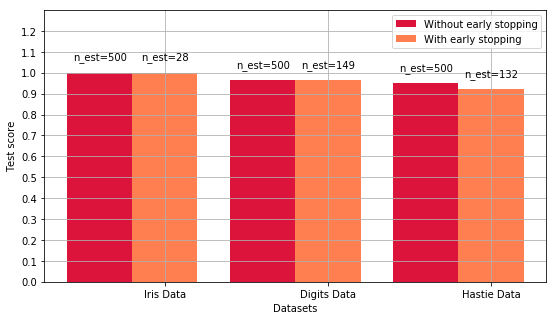

In [132]:
plt.figure(figsize=(9, 5))

bar1 = plt.bar(index, score_gb, bar_width, label='Without early stopping',
               color='crimson')
bar2 = plt.bar(index + bar_width, score_gbes, bar_width,
               label='With early stopping', color='coral')

plt.xticks(index + bar_width, names)
plt.yticks(np.arange(0, 1.3, 0.1))


def autolabel(rects, n_estimators):
    """
    Attach a text label above each bar displaying n_estimators of each model
    """
    for i, rect in enumerate(rects):
        plt.text(rect.get_x() + rect.get_width() / 2.,
                 1.05 * rect.get_height(), 'n_est=%d' % n_estimators[i],
                 ha='center', va='bottom')


autolabel(bar1, n_gb)
autolabel(bar2, n_gbes)

plt.ylim([0, 1.3])
plt.legend(loc='best')
plt.grid(True)

plt.xlabel('Datasets')
plt.ylabel('Test score')

plt.show()

### Compare fit times with and without early stopping


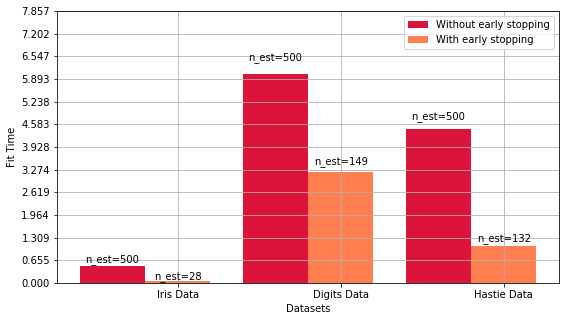

In [133]:
plt.figure(figsize=(9, 5))

bar1 = plt.bar(index, time_gb, bar_width, label='Without early stopping',
               color='crimson')
bar2 = plt.bar(index + bar_width, time_gbes, bar_width,
               label='With early stopping', color='coral')

max_y = np.amax(np.maximum(time_gb, time_gbes))

plt.xticks(index + bar_width, names)
plt.yticks(np.linspace(0, 1.3 * max_y, 13))

autolabel(bar1, n_gb)
autolabel(bar2, n_gbes)

plt.ylim([0, 1.3 * max_y])
plt.legend(loc='best')
plt.grid(True)

plt.xlabel('Datasets')
plt.ylabel('Fit Time')

plt.show()